In [2]:
import pandas as pd
import re
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

In [3]:
import torch
import torch_directml  # Correct way to use DirectML with PyTorch

# Initialize DirectML device
device = torch_directml.device()
print(f"Using device: {device}")

# Test tensor on GPU
tensor = torch.ones(5, device=device)
print(tensor)

Using device: privateuseone:0
tensor([1., 1., 1., 1., 1.], device='privateuseone:0')


In [4]:
# Load the data
drive_path = "C:/ML/separated_postings.csv"
df = pd.read_csv(drive_path, engine="python", on_bad_lines='skip')

In [5]:
# Preprocess the text data
def preprocess(text):
    text = re.sub(r'\W+', ' ', str(text).lower())  # Remove special characters and lowercase
    return text


In [6]:
df['clean_text'] = df.iloc[:, 0].dropna().apply(preprocess)  # Assuming job postings are in the first column
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
text_matrix = vectorizer.fit_transform(df['clean_text'].dropna())

In [7]:
# Fit LDA model
num_topics = 10  # Adjust based on your data
lda_model = LDA(n_components=num_topics, random_state=42)
lda_matrix = lda_model.fit_transform(text_matrix)


In [8]:
# Display the topics with top words
def display_topics(model, feature_names, num_top_words=100):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[-num_top_words:]]))

In [9]:
display_topics(lda_model, vectorizer.get_feature_names_out())


Topic 1:
technology executive provide career looking driven formatted_experience_level leadership zip_code passion manage brands self fast learn day excellent learning selling world grow results speciality strategies client join business_development building strategy ensure responsibilities vision paid lead events com clients years culture performance training needs help job full_time key service make social based benefits working creative position goals store teams develop account best ll high opportunity level support build create digital content people communication management drive relationships success retail products development brand market environment media manager opportunities strong including growth customers ability role product company new skills business customer work marketing team sales

Topic 2:
account value full_time program impact offer build required identity color bank related programs level internal degree applicable ll service veteran origin religion compliance

In [10]:
import umap

# Apply UMAP for dimensionality reduction
umap_reducer = umap.UMAP(random_state=42)
lda_umap = umap_reducer.fit_transform(lda_matrix)  # Renamed variable

C:\Users\nicole\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\nicole\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\nicole\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


In [65]:
dominant_topics = lda_matrix.argmax(axis=1)


In [66]:
feature_names = vectorizer.get_feature_names_out()


In [67]:
word_topic_assignments = lda_model.components_.argmax(axis=0)


In [68]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import colorsys

In [69]:
topic_colors = cm.get_cmap('tab10', num_topics)  # Adjust based on number of topics

C:\Users\nicole\AppData\Local\Temp\ipykernel_9032\4227479930.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  topic_colors = cm.get_cmap('tab10', num_topics)  # Adjust based on number of topics


In [70]:
# Function to lighten colors for better readability
def lighten_color(rgb_color, factor=1.6):
    """Lightens an RGB color for better contrast."""
    h, l, s = colorsys.rgb_to_hls(*rgb_color[:3])
    l = min(1, l * factor)
    return colorsys.hls_to_rgb(h, l, s)

In [71]:
# Compute centroids properly
topic_centroids = {}
for topic_id in range(num_topics):
    topic_points = lda_umap[dominant_topics == topic_id]  # Ensure matching shapes
    if len(topic_points) > 0:
        centroid = topic_points.mean(axis=0)
    else:
        centroid = np.array([0, 0])  # Avoids indexing issues
    topic_centroids[topic_id] = centroid


In [72]:
# Updated annotation function with outline and larger text
def annotate_words_lda(word_list, feature_names, lda_model, topic_centroids):
    for word in word_list:
        if word in feature_names:
            word_idx = np.where(feature_names == word)[0][0]
            dominant_topic = word_topic_assignments[word_idx]
            x, y = topic_centroids.get(dominant_topic, (0, 0))

            # Get original topic color and lighten it
            original_color = topic_colors(dominant_topic)[:3]
            lightened_color = lighten_color(original_color, factor=1.5)

            # Add annotation with outline (shadow effect)
            plt.text(
                x, y, word,
                fontsize=14,  # Larger font
        
            )

C:\Users\nicole\AppData\Local\Temp\ipykernel_9032\2478140832.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95], pad=1.5, h_pad=1.5, w_pad=1.5)


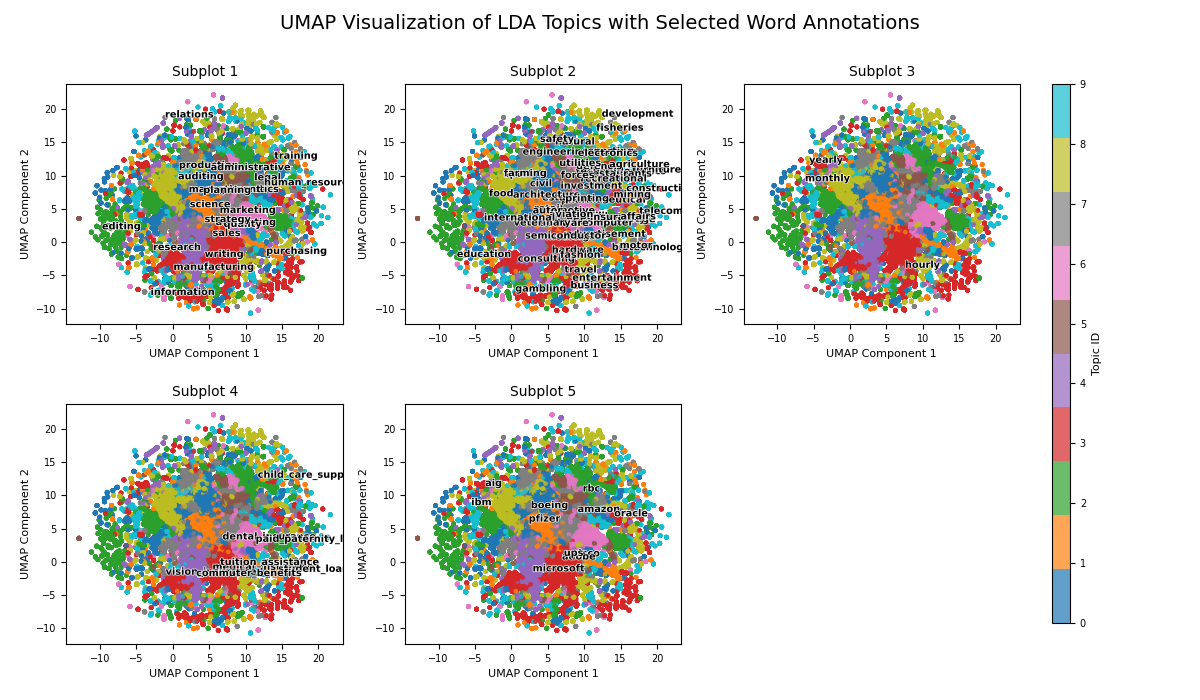

In [73]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

%matplotlib widget

# Create a 2x3 grid of subplots with reduced figure size (only 5 plots needed)
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle('UMAP Visualization of LDA Topics with Selected Word Annotations', fontsize=14)

# Remove the last empty subplot
fig.delaxes(axes[1, 2])
axes = axes.flatten()[:5]

# Scatter plot with topic colors on each subplot
for i, ax in enumerate(axes):
    scatter = ax.scatter(
        lda_umap[:, 0], 
        lda_umap[:, 1], 
        c=dominant_topics, 
        cmap='tab10', 
        s=6, 
        alpha=0.7
    )
    ax.set_title(f'Subplot {i+1}', fontsize=10)
    ax.set_xlabel('UMAP Component 1', fontsize=8)
    ax.set_ylabel('UMAP Component 2', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=7)

# List of data for each subplot
data = [
    (['Advertising', 'Art', 'Creative', 'Design', 'Distribution', 'Consulting', 'Analyst', 'Health', 'Care', 'science',
      'mathematics', 'legal', 'quality', 'information', 'relations', 'writing', 'editing', 'accounting', 'auditing',
      'manufacturing', 'sales', 'management', 'marketing', 'production', 'administrative', 'research', 'quality',
      'strategy', 'planning', 'purchasing', 'training', 'human_resources'], 'Skills'),
      
    (['technology', 'business', 'medicine', 'law', 'engineering', 'retail', 'food', 'apparel', 'entertainment', 'gambling',
      'design', 'investment', 'education', 'logistics', 'advertisement', 'beverage', 'natural', 'automotive', 'security',
      'ai', 'blockchain', 'defence', 'computer', 'hardware', 'software', 'development', 'semiconductor',
      'telecommunications', 'consulting', 'biotechnology', 'pharmaceutical', 'veterinary', 'fashion', 'sport',
      'sporting', 'electronics', 'furniture', 'travel', 'restaurants', 'recreational', 'insurance', 'estate',
      'construction', 'architecture', 'civil', 'aviation', 'motor', 'mining', 'utilities', 'farming', 'agriculture',
      'fisheries', 'forces', 'international', 'affairs', 'safety', 'printing'], 'Industry'),
          
    (['hourly', 'yearly', 'monthly'], 'Pay Period'),
    
    (['medical_insurance', 'vision_insurance', 'tuition_assistance', '401_(k)', 'dental_insurance',
      'student_loan_assistance', 'disabililty_insurance', 'child_care_support', 'commuter_benefits',
      'paid_paternity_leave'], 'Benefits'),
      
    (['ibm', 'accenture', 'oracle', 'microsoft', 'cisco', 'nxp', 'pfizer', 'atos', 'honeywell', 'pepsiCo',
      'carestream', 'amazon', 'rbc', 'oracle', 'ge_healthcare', 'hawlett_packard_enterprise', 'bt_group', 'atos',
      'boeing', 'adobe', 'sanofi', 'harvard_university', 'aig', 'charles_schwab', 'medtronic', 'ups'], 'Company')
]

# Annotate only the selected words
for ax, (words, _) in zip(axes, data):
    for word in words:
        if word in vectorizer.vocabulary_:
            idx = vectorizer.vocabulary_[word]
            x, y = lda_umap[idx]
            txt = ax.annotate(
                word, 
                xy=(x, y), 
                xytext=(0, 0), 
                textcoords='offset points',
                fontsize=7, 
                weight='bold', 
                color='black',
                clip_on=True,  # Keeps text within plot bounds during zoom
                path_effects=[path_effects.Stroke(linewidth=1, foreground='white'), path_effects.Normal()]
            )

# Add colorbar to the rightmost subplot
cbar = plt.colorbar(
    scatter, 
    ax=axes, 
    label='Topic ID', 
    fraction=0.03, 
    pad=0.08, 
    aspect=30
)
cbar.ax.tick_params(labelsize=7)
cbar.set_label('Topic ID', fontsize=8)

# Tight layout with adjusted padding
plt.tight_layout(rect=[0, 0, 1, 0.95], pad=1.5, h_pad=1.5, w_pad=1.5)
plt.subplots_adjust(top=0.88, right=0.85)
plt.show()


In [20]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
lda_tsne = tsne.fit_transform(lda_matrix)


In [74]:
# Compute dominant topics for each document
dominant_topics = lda_matrix.argmax(axis=1)

In [75]:
# Calculate cluster centroids for each topic
topic_centroids = {}
for topic_id in range(num_topics):
    topic_points = lda_tsne[dominant_topics == topic_id]
    if len(topic_points) > 0:
        centroid = topic_points.mean(axis=0)
    else:
        centroid = (0, 0)  # Fallback for empty clusters
    topic_centroids[topic_id] = centroid

In [76]:
# Function to annotate words at their dominant topic's centroid
def annotate_words_lda(word_list, vectorizer, lda_model, topic_centroids):
    feature_names = vectorizer.get_feature_names_out()
    for word in word_list:
        if word in feature_names:
            word_idx = list(feature_names).index(word)
            # Find the topic where the word has the highest weight
            word_topic_weights = lda_model.components_[:, word_idx]
            dominant_topic = word_topic_weights.argmax()
            # Annotate at the centroid of that topic
            x, y = topic_centroids[dominant_topic]
            plt.annotate(
                word, 
                (x, y), 
                fontsize=12, 
                color='black', 
                ha='center',
            )


C:\Users\nicole\AppData\Local\Temp\ipykernel_9032\971736669.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95], pad=1.5, h_pad=1.5, w_pad=1.5)


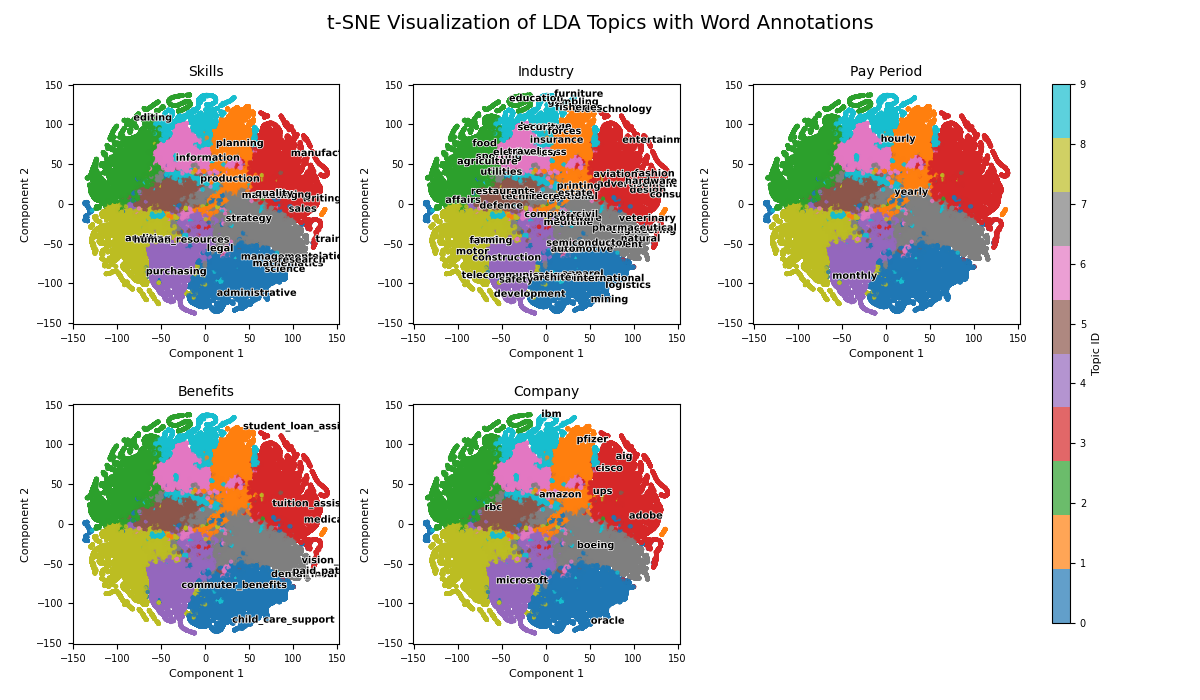

In [77]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

%matplotlib widget

# Define data categories and word lists
data = [
    (['Advertising', 'Art', 'Creative', 'Design', 'Distribution', 'Consulting', 'Analyst', 'Health', 'Care', 'science', 
      'mathematics', 'legal', 'quality', 'information', 'relations', 'writing', 'editing', 'accounting', 'auditing', 
      'manufacturing', 'sales', 'management', 'marketing', 'production', 'administrative', 'research', 'quality',
      'strategy', 'planning', 'purchasing', 'training', 'human_resources'], 'Skills'),
      
    (['technology', 'business', 'medicine', 'law', 'engineering', 'retail', 'food', 'apparel', 'entertainment', 'gambling',
      'design', 'investment', 'education', 'logistics', 'advertisement', 'beverage', 'natural', 'automotive', 'security', 
      'ai', 'blockchain', 'defence', 'computer', 'hardware', 'software', 'development', 'semiconductor', 
      'telecommunications', 'consulting', 'biotechnology', 'pharmaceutical', 'veterinary', 'fashion', 'sport', 
      'sporting', 'electronics', 'furniture', 'travel', 'restaurants', 'recreational', 'insurance', 'estate', 
      'construction', 'architecture', 'civil', 'aviation', 'motor', 'mining', 'utilities', 'farming', 'agriculture', 
      'fisheries', 'forces', 'international', 'affairs', 'safety', 'printing'], 'Industry'),
          
    (['hourly', 'yearly', 'monthly'], 'Pay Period'),
    
    (['medical_insurance', 'vision_insurance', 'tuition_assistance', '401_(k)', 'dental_insurance', 
      'student_loan_assistance', 'disabililty_insurance', 'child_care_support', 'commuter_benefits', 
      'paid_paternity_leave'], 'Benefits'),
      
    (['ibm', 'accenture', 'oracle', 'microsoft', 'cisco', 'nxp', 'pfizer', 'atos', 'honeywell', 'pepsiCo', 
      'carestream', 'amazon', 'rbc', 'oracle', 'ge_healthcare', 'hawlett_packard_enterprise', 'bt_group', 'atos', 
      'boeing', 'adobe', 'sanofi', 'harvard_university', 'aig', 'charles_schwab', 'medtronic', 'ups'], 'Company')
]

# Adjust figure size and layout parameters
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle('t-SNE Visualization of LDA Topics with Word Annotations', fontsize=14)

# Remove the last empty subplot
fig.delaxes(axes[1, 2])
axes = axes.flatten()[:5]

# Iterate through data and plot in respective subplot
for ax, (annotations, title) in zip(axes.flat, data):
    scatter = ax.scatter(
        lda_tsne[:, 0], 
        lda_tsne[:, 1], 
        c=dominant_topics, 
        cmap='tab10', 
        s=5, 
        alpha=0.7
    )
    
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Component 1', fontsize=8)
    ax.set_ylabel('Component 2', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=7)
    
    # Annotate specified words with smaller text
    for word in annotations:
        if word in vectorizer.vocabulary_:
            idx = vectorizer.vocabulary_[word]
            x, y = lda_tsne[idx]
            txt = ax.annotate(
                word, 
                xy=(x, y), 
                xytext=(0, 0), 
                textcoords='offset points',
                fontsize=7, 
                weight='bold', 
                color='black',
                path_effects=[path_effects.Stroke(linewidth=1, foreground='white'), path_effects.Normal()],
                clip_on=True  # Ensures text stays within plot bounds
            )

# Adjust colorbar size and position
cbar = plt.colorbar(
    scatter, 
    ax=axes.ravel().tolist(), 
    label='Topic ID', 
    fraction=0.03, 
    pad=0.08, 
    aspect=30
)
cbar.ax.tick_params(labelsize=7)
cbar.set_label('Topic ID', fontsize=8)

# Tight layout with adjusted padding
plt.tight_layout(rect=[0, 0, 1, 0.95], pad=1.5, h_pad=1.5, w_pad=1.5)
plt.subplots_adjust(top=0.88, right=0.85)
plt.show()


In [78]:
from sklearn.decomposition import LatentDirichletAllocation as LDA, TruncatedSVD

# Apply Truncated SVD 
svd = TruncatedSVD(n_components=2, random_state=42)
lda_svd = svd.fit_transform(lda_matrix)  # Reduces LDA topics to 2D

In [79]:
# Compute dominant topics and centroids
dominant_topics = lda_matrix.argmax(axis=1)
topic_centroids = {}
for topic_id in range(num_topics):
    topic_points = lda_svd[dominant_topics == topic_id]
    centroid = topic_points.mean(axis=0) if len(topic_points) > 0 else (0, 0)
    topic_centroids[topic_id] = centroid

In [80]:
# Function to annotate words at their dominant topic's centroid
def annotate_words_lda(word_list, vectorizer, lda_model, topic_centroids):
    feature_names = vectorizer.get_feature_names_out()
    for word in word_list:
        if word in feature_names:
            word_idx = list(feature_names).index(word)
            dominant_topic = lda_model.components_[:, word_idx].argmax()
            x, y = topic_centroids[dominant_topic]
            plt.annotate(
                word, (x, y), 
                fontsize=12, ha='center', color='black',  # Make text BLACK
            )


C:\Users\nicole\AppData\Local\Temp\ipykernel_9032\266266384.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95], pad=1.5, h_pad=1.5, w_pad=1.5)


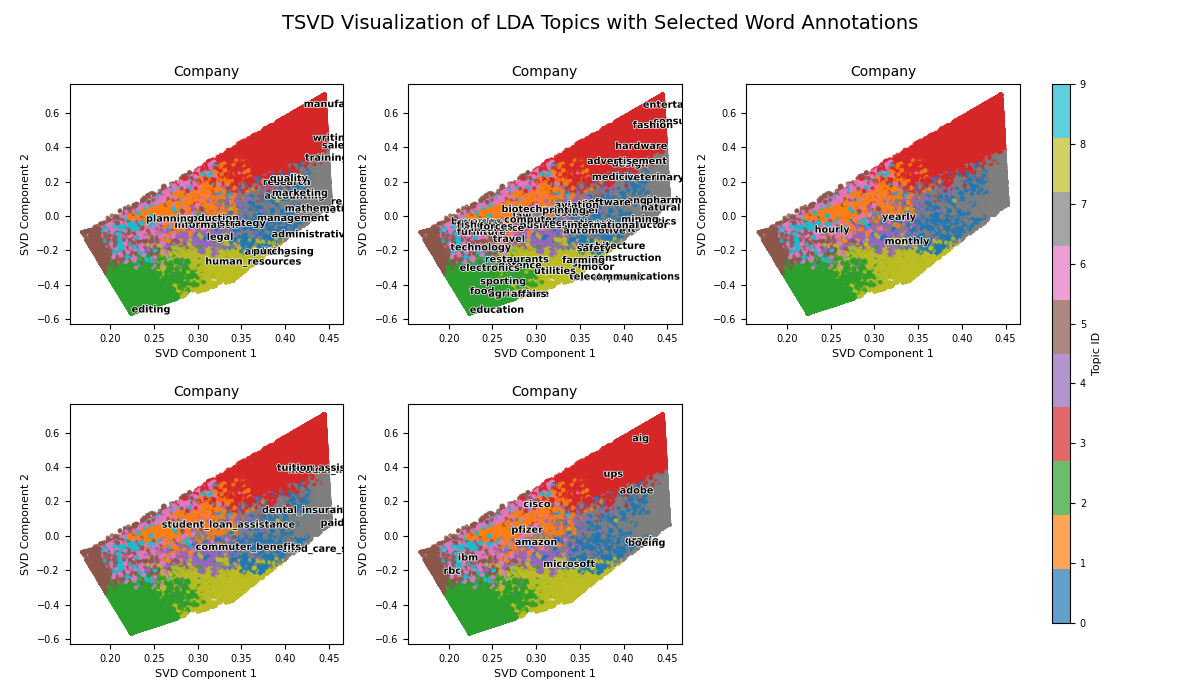

In [82]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

%matplotlib widget

# Create a 2x3 grid of subplots with reduced figure size
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
fig.suptitle('TSVD Visualization of LDA Topics with Selected Word Annotations', fontsize=14)

# Remove the last empty subplot
fig.delaxes(axes[1, 2])
axes = axes.flatten()[:5]

# Scatter plot with topic colors on each subplot
for i, ax in enumerate(axes.flatten()):
    scatter = ax.scatter(
        lda_svd[:, 0], 
        lda_svd[:, 1], 
        c=dominant_topics, 
        cmap='tab10', 
        s=5, 
        alpha=0.7
    )
    ax.set_title(title, fontsize=10)

    ax.set_xlabel('SVD Component 1', fontsize=8)
    ax.set_ylabel('SVD Component 2', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=7)

# List of data for each subplot
data = [
    (['Advertising', 'Art', 'Creative', 'Design', 'Distribution', 'Consulting', 'Analyst', 'Health', 'Care', 'science',
      'mathematics', 'legal', 'quality', 'information', 'relations', 'writing', 'editing', 'accounting', 'auditing',
      'manufacturing', 'sales', 'management', 'marketing', 'production', 'administrative', 'research', 'quality',
      'strategy', 'planning', 'purchasing', 'training', 'human_resources'], 'Skills'),
      
    (['technology', 'business', 'medicine', 'law', 'engineering', 'retail', 'food', 'apparel', 'entertainment', 'gambling',
      'design', 'investment', 'education', 'logistics', 'advertisement', 'beverage', 'natural', 'automotive', 'security',
      'ai', 'blockchain', 'defence', 'computer', 'hardware', 'software', 'development', 'semiconductor',
      'telecommunications', 'consulting', 'biotechnology', 'pharmaceutical', 'veterinary', 'fashion', 'sport',
      'sporting', 'electronics', 'furniture', 'travel', 'restaurants', 'recreational', 'insurance', 'estate',
      'construction', 'architecture', 'civil', 'aviation', 'motor', 'mining', 'utilities', 'farming', 'agriculture',
      'fisheries', 'forces', 'international', 'affairs', 'safety', 'printing'], 'Industry'),
          
    (['hourly', 'yearly', 'monthly'], 'Pay Period'),
    
    (['medical_insurance', 'vision_insurance', 'tuition_assistance', '401_(k)', 'dental_insurance',
      'student_loan_assistance', 'disabililty_insurance', 'child_care_support', 'commuter_benefits',
      'paid_paternity_leave'], 'Benefits'),
      
    (['ibm', 'accenture', 'oracle', 'microsoft', 'cisco', 'nxp', 'pfizer', 'atos', 'honeywell', 'pepsiCo',
      'carestream', 'amazon', 'rbc', 'oracle', 'ge_healthcare', 'hawlett_packard_enterprise', 'bt_group', 'atos',
      'boeing', 'adobe', 'sanofi', 'harvard_university', 'aig', 'charles_schwab', 'medtronic', 'ups'], 'Company')
]

# Annotate only the selected words
for ax, (words, _) in zip(axes.flatten(), data):
    for word in words:
        if word in vectorizer.vocabulary_:
            idx = vectorizer.vocabulary_[word]
            x, y = lda_svd[idx]
            txt = ax.annotate(
                word, 
                xy=(x, y), 
                xytext=(0, 0), 
                textcoords='offset points',
                fontsize=7, 
                weight='bold', 
                color='black',
                clip_on=True,  # Keeps text within plot bounds during zoom
                path_effects=[path_effects.Stroke(linewidth=1, foreground='white'), path_effects.Normal()]
            )

# Add colorbar to the rightmost subplot
cbar = plt.colorbar(
    scatter, 
    ax=axes.ravel().tolist(), 
    label='Topic ID', 
    fraction=0.03, 
    pad=0.08, 
    aspect=30
)
cbar.ax.tick_params(labelsize=7)
cbar.set_label('Topic ID', fontsize=8)

# Tight layout with adjusted padding
plt.tight_layout(rect=[0, 0, 1, 0.95], pad=1.5, h_pad=1.5, w_pad=1.5)
plt.subplots_adjust(top=0.88, right=0.85)
plt.show()
